# DataScience for Good: DonersChoose.org

The below will include the kernel for an investigation into the doner modelling from the data publicly available at Kaggle - https://www.kaggle.com/donorschoose/io/data


The problem description from Kaggle:

A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors. Part of the challenge is to assess the needs of the organization, uncover insights from the data available, and build the right solution for this problem. Submissions will be evaluated on the following criteria:

    Performance - How well does the solution match donors to project requests to which they would be motivated to donate? DonorsChoose.org will not be able to live test every submission, so a strong entry will clearly articulate why it will be effective at motivating repeat donations.

    Adaptable - The DonorsChoose.org team wants to put the winning submissions to work, quickly. Therefore a good entry will be easy to implement in production.

    Intelligible - A good entry should be easily understood by the DonorsChoose.org team should it need to be updated in the future to accommodate a changing marketplace.


## Working with the data

This Notebook will explore the Donations.csv provided by DonorsChoose.org partnered with Google.org and document the process that will begin with performing basic descriptive statistics, to finalising a survival model which will predict the likelihood of donor dropoff.

Follow along in your own python session if you want to have ago yourself. I'm working in Python 3.5 right now, my admin has been slacking recently XD. You'll need the following packages installed with pip:

numpy
pandas
matplotlib



In [1]:
import datetime as dt
import pandas as pd
import numpy as np

columns = ['Project ID',
          'Donation ID',
          'Donor ID',
          'Donation Included Optional Donation',
          'Donation Amount',
          'Donor Cart Sequence',
          'Donation Received Date']

dtypes = {'Project ID': object,
          'Donation ID': object,
          'Donor ID': object,
          'Donation Included Optional Donation': object,
          'Donation Amount': np.float64,
          'Donor Cart Sequence': np.float64,
          'Donation Received Date': object}

PATH = 'C:/Users/ssamdj/Documents/python/doners'
#PATH = '/home/mj/datawarehouse/io'

#needed header=0 as names was passed to the function, but first line of csv contains column titles. This ensures they're not converted
donations = pd.read_csv(PATH+'/Donations.csv', names = columns, header=0, dtype = dtypes, infer_datetime_format=True, parse_dates=True, low_memory=False)
donors = pd.read_csv(PATH+'/Donors.csv', header=0, infer_datetime_format=True, parse_dates=True, low_memory=False)
#projects = pd.read_csv(PATH+'/Projects.csv', header=0, infer_datetime_format=True, parse_dates=True, low_memory=False)
#resources = pd.read_csv(PATH+'/Resources.csv', header=0, infer_datetime_format=True, parse_dates=True, low_memory=False)
#schools = pd.read_csv(PATH+'/Schools.csv', names = columns, header=0, dtype = dtypes, infer_datetime_format=True, parse_dates=True, low_memory=False)
#teachers = pd.read_csv(PATH+'/Teachers.csv', names = columns, header=0, dtype = dtypes, infer_datetime_format=True, parse_dates=True, low_memory=False)



## Initial Data Profiling

At the onset of any new project, I always like to find my bearings. Determining some high level statistical data can help to provide this picture. Descriptive statistics is the most basic form of data analysis and is essential to an effective workflow. Following, this, visualising the data is another important skillset to have in your back pocket. 

In [2]:
print('Donations: \n','Rows: ', donations.shape[0], 'Columns: ', donations.shape[1])
print(donations.dtypes)
print('Donors: \n','Rows: ', donors.shape[0], 'Columns: ', donors.shape[1])
print(donors.dtypes)
#print('Projects: \n','Rows: ', projects.shape[0], 'Columns: ', projects.shape[1])
#print(projects.dtypes)
#print('Resources: \n','Rows: ', resources.shape[0], 'Columns: ', resources.shape[1])
#print(resources.dtypes)
#print('Schools: \n','Rows: ', schools.shape[0], 'Columns: ', schools.shape[1])
#print('Teachers: \n','Rows: ', teachers.shape[0], 'Columns: ', teachers.shape[1])

Donations: 
 Rows:  4687884 Columns:  7
Project ID                              object
Donation ID                             object
Donor ID                                object
Donation Included Optional Donation     object
Donation Amount                        float64
Donor Cart Sequence                    float64
Donation Received Date                  object
dtype: object
Donors: 
 Rows:  2122640 Columns:  5
Donor ID            object
Donor City          object
Donor State         object
Donor Is Teacher    object
Donor Zip           object
dtype: object


Slow and steady now! Okay, so the dataframe that we've loaded with the Donations.csv has 4 687 884 rows! That's some hefty data. Fortunately we've only got 7 columns to work with, which have been defined earlier. 

I think we'll need to enrich this data with some additional statistical information on the donor level to create these predictors of survive. We'll cross that bridge when we get there. 

In [3]:
print("The minimum donation amount is: $", donations['Donation Amount'].min())
print("The maximum donation amount is: $", donations['Donation Amount'].max())
print("The average donation amount is: $", donations['Donation Amount'].mean())
df_mode = donations['Donation Amount'].mode() #note the mode outputs a dataframe where each row would identify the most common element in the case of ties.
print("The most common donation amount is: $", df_mode.iloc[0])


The minimum donation amount is: $ 0.01
The maximum donation amount is: $ 60000.0
The average donation amount is: $ 60.6687885792
The most common donation amount is: $ 25.0


That tell's us a little more. Donations vary - from as little as \$0.01 to \$60 000, whilst the mean is \$60.67. The mean is a measure of centrality, but it isn't necessarily the best one to use in this kind of data set. From my own personal experience, I believe that this data set would be fairly right skewed (long tail to the right of the mean). A priori, I would guess that there would be a lot of smaller donations, and fewer at the high end. The mode gives me extra motivation that this is indeed the case.

Don't forget to apply your own intuitions to the data - ask yourself what your prior knowledge or assumptions might be, and always challenge them.

Sometimes the median - the middle item in an ordered list would be more appropriate. If the distribution of the donation amounts was symmetrically normal, then the median and means should be the same.

In [55]:
print("The middle donation amount is: $", donations['Donation Amount'].median())


The middle donation amount is: $ 25.0


Ha! Knew it! Funnily enough, the most common donation is the same as the middle donation. That doesn't always happen like that. 

We can also do some further investigatory work to measure the spread of values across the distribution. Some inter-quantile information, and calculating the standard deviation should help us here.

In [56]:
print("The standard deviation is: $", donations['Donation Amount'].std())
print("The variance is: $", donations['Donation Amount'].var())
print("The 1st, 2nd, 3rd quantiles are: \n", donations['Donation Amount'].quantile([0.25, 0.50, 0.75]))

The standard deviation is: $ 166.899615325
The variance is: $ 27855.4815956
The 1st, 2nd, 3rd quantiles are: 
 0.25    14.82
0.50    25.00
0.75    50.00
Name: Donation Amount, dtype: float64


These statistice are a little more difficult to interpret, but the standard deviation can be used to estimate what proportion of the population lies within specific intervals around the mean. For instance, approximately  between 1 Standard Deviation above and below the mean. The higher the standard deivation, the greater the spread. Variance is a similar concept and can also be expressed as the square of the standard deviation.

The quartiles are the cutoff points for each population quarter of the population. 25% of the donation amounts are below \$14.82, 50% are below \$25, etc.

## Nullity

Checking the proportionality of null columns in the tables is a very important step in profiling the data you want to work with. Ultimately it'll lead to more questions - like, why is the data null? do nulls only affect certain groups? How we treat nulls in our analysis is another decision point. 

In [6]:
print('Null Values for Donations.csv: ', donations.isnull().sum())
print('Null Values for Donors.csv: ', donors.isnull().sum())


Null Values for Donations.csv:  Project ID                             0
Donation ID                            0
Donor ID                               0
Donation Included Optional Donation    0
Donation Amount                        0
Donor Cart Sequence                    0
Donation Received Date                 0
dtype: int64
Null Values for Donors.csv:  Donor ID                 0
Donor City          213097
Donor State              0
Donor Is Teacher         0
Donor Zip           180060
dtype: int64


Overall Donations.csv is complete, but Donors.csv has a some 200000+ missings for City and Zip, which might be problematic if we're going to do some geographical based analysis.

## Some Data Preparation

We enhance the donor data by creating additional columns which generate some statistical data based on 

In [7]:
#Note the as_index option will enable the datasets to be joined. The default behaviour of the groupby method is to make the groupby variable an index.
df_by_donor = donations[['Donor ID','Donation ID', 'Donation Amount', 'Donation Received Date']].groupby('Donor ID', as_index=False).agg({'Donation ID': 'count', 'Donation Received Date': 'max', 'Donation Amount': ['min', 'max', 'mean', 'sum']})

In [8]:
df_by_donor.columns

MultiIndex(levels=[['Donation Received Date', 'Donation ID', 'Donation Amount', 'Donor ID'], ['count', 'max', 'mean', 'min', 'sum', '']],
           labels=[[3, 0, 1, 2, 2, 2, 2], [5, 1, 0, 3, 1, 2, 4]])

The dataframe we've just created df_donor_donations contains a multi-level index, and as such, needs to be treated differently when renaming. I personally prefer to have a flatter structure when dealing with pandas data frames. We can check this by printing the following:

In [9]:
print(df_by_donor.columns.get_level_values(0))
print(df_by_donor.columns.get_level_values(1))

Index(['Donor ID', 'Donation Received Date', 'Donation ID', 'Donation Amount',
       'Donation Amount', 'Donation Amount', 'Donation Amount'],
      dtype='object')
Index(['', 'max', 'count', 'min', 'max', 'mean', 'sum'], dtype='object')


We can see here that we have a multi-level index. This can sometimes also occur when we use pivot tables. One way of flattening this has been discussed on Stack Overflow - https://stackoverflow.com/questions/14507794/python-pandas-how-to-flatten-a-hierarchical-index-in-columns.

The approach by Andy Hayden is employed below.

In [10]:
df_by_donor.columns = [' '.join(col).strip() for col in df_by_donor.columns.values]

Let's see how that has worked.


In [11]:
print(df_by_donor.head())

                           Donor ID Donation Received Date max  \
0  00000ce845c00cbf0686c992fc369df4        2013-12-17 21:47:14   
1  00002783bc5d108510f3f9666c8b1edd        2016-02-02 18:34:27   
2  00002d44003ed46b066607c5455a999a        2017-10-18 14:34:11   
3  00002eb25d60a09c318efbd0797bffb5        2018-01-16 15:32:41   
4  0000300773fe015f870914b42528541b        2017-02-26 11:52:14   

   Donation ID count  Donation Amount min  Donation Amount max  \
0                  1                50.00                 50.0   
1                  1                99.00                 99.0   
2                 11                 9.69                150.0   
3                  5                10.00                 50.0   
4                  1                50.00                 50.0   

   Donation Amount mean  Donation Amount sum  
0             50.000000                50.00  
1             99.000000                99.00  
2             57.722727               634.95  
3             42.0

I think I can spruce up those names a bit.

In [12]:
df_by_donor.rename(columns = {'Donor ID': 'Donor ID', 'Donation Amount min': 'Minimum Donation', 'Donation Amount max': 'Maximum Donation', 'Donation Amount mean': 'Mean Donation', 'Donation Amount sum': 'Total Donations', 'Donation ID count': 'Count of Donations by Donor', 'Donation Received Date max': 'Most Recent Donation'}, inplace=True)
print(df_by_donor.head())

                           Donor ID Most Recent Donation  \
0  00000ce845c00cbf0686c992fc369df4  2013-12-17 21:47:14   
1  00002783bc5d108510f3f9666c8b1edd  2016-02-02 18:34:27   
2  00002d44003ed46b066607c5455a999a  2017-10-18 14:34:11   
3  00002eb25d60a09c318efbd0797bffb5  2018-01-16 15:32:41   
4  0000300773fe015f870914b42528541b  2017-02-26 11:52:14   

   Count of Donations by Donor  Minimum Donation  Maximum Donation  \
0                            1             50.00              50.0   
1                            1             99.00              99.0   
2                           11              9.69             150.0   
3                            5             10.00              50.0   
4                            1             50.00              50.0   

   Mean Donation  Total Donations  
0      50.000000            50.00  
1      99.000000            99.00  
2      57.722727           634.95  
3      42.000000           210.00  
4      50.000000            50.00  


Much better. The final steps are to merge these data sets. I'll join 'df_by_donor' onto the original source data frame to enrich the data for visualisation. The easiest way to enrich the original data set is to perform a left join which the main data set listed as the 'left' table. Again, here we can use the pd.merge method, but change the 'how' option to left. 

Secondly, we'll merge with the donors data to gain some more geographic data about location.

In [13]:
df2 = pd.merge(donations, df_by_donor, how='inner', on='Donor ID')
df3 = pd.merge(df2, donors, how='inner', on='Donor ID')
print(df3.head())

                         Project ID                       Donation ID  \
0  000009891526c0ade7180f8423792063  688729120858666221208529ee3fc18e   
1  016510b8226e70d740130ac2dcfb6c5e  f7fc7cf0b8980fb00840b4afe7c1e761   
2  03c8766872a129240d14be8c385b5f1a  5015b2df023ed47e7609e91ca65f7559   
3  04bfceb168d816a3cbe52f1e70d30bf0  b8871d3666020f0a527c8d6b56361d1e   
4  05a4e3418a97f2df3a6cc8ae8fbde60c  8bc4de01f65d42a611236e083c6f3473   

                           Donor ID Donation Included Optional Donation  \
0  1f4b5b6e68445c6c4a0509b3aca93f38                                  No   
1  1f4b5b6e68445c6c4a0509b3aca93f38                                  No   
2  1f4b5b6e68445c6c4a0509b3aca93f38                                  No   
3  1f4b5b6e68445c6c4a0509b3aca93f38                                  No   
4  1f4b5b6e68445c6c4a0509b3aca93f38                                  No   

   Donation Amount  Donor Cart Sequence Donation Received Date  \
0           178.37                 11.0    2

## Handling Time Series Data

The Donation data that we've been given is a time-series which means that the relationships that we might like to draw (say donations forecasting) are time dependent. There is likely to be sensitivity in the data due to seasonality, or drop-off of donors for various reasons.

I will ensure that our datetime variables are properly interpreted as a datetime number.

In [14]:
df3['Donation Received Date'] = pd.to_datetime(df3['Donation Received Date'])
df3['Most Recent Donation'] = pd.to_datetime(df3['Most Recent Donation'])

I like to group my data further more
Now is a good time to do some more feature creation before we dive head first into Visualising the content. In particular, it's sometimes a good idea to create Month, Year, Month-Year variables that will allow for better grouping through time. This will reduce the performance required of plotting by reducing the number of individual points.

In [15]:
df3['Donation Received Month'] = df3['Donation Received Date'].dt.month
df3['Donation Received Year'] = df3['Donation Received Date'].dt.year
df3['Donation Received Month-Year'] = df3['Donation Received Date'].dt.to_period('M')
df3.sort_values(by='Donation Received Date', inplace=True, ascending= True)

In [16]:
df3_month = df3[['Donation Received Month-Year', 'Donor ID', 'Donation Amount']].groupby(by='Donation Received Month-Year', as_index=False).agg({'Donation Amount': ['min', 'max', 'mean', 'sum', 'count'], 'Donor ID': pd.Series.nunique})
df3_month.columns = [' '.join(col).strip() for col in df3_month.columns.values]
df3_month.rename(columns = {'Donor ID nunique': 'Count of Unique Donors', 'Donation Amount min': 'Minimum Donation', 'Donation Amount max': 'Maximum Donation', 'Donation Amount mean': 'Mean Donation', 'Donation Amount sum': 'Total Donations', 'Donation Amount count': 'Count of Donations'}, inplace=True)

## Visualising the Data

Visualising the data is an important step to understanding it. Pictures are worth 1 000 words. Okay with that in mind, we'll need to import the Matplotlib to start, and then we'll try and plot a distribution of the donations over the course of the time period to get a better understanding of the spread of donations with respect to time. 

In [17]:
import matplotlib.pyplot as plt
df3_month.columns

Index(['Donation Received Month-Year', 'Count of Unique Donors',
       'Minimum Donation', 'Maximum Donation', 'Mean Donation',
       'Total Donations', 'Count of Donations'],
      dtype='object')

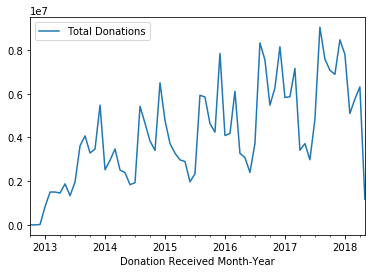

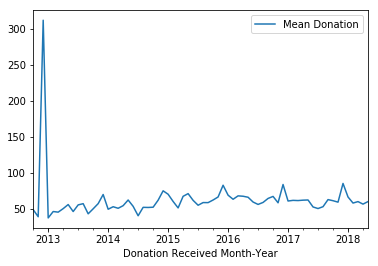

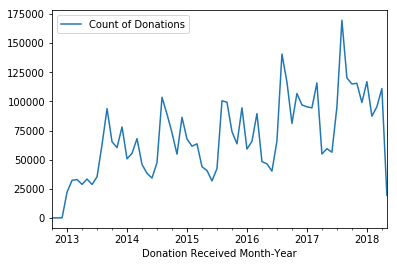

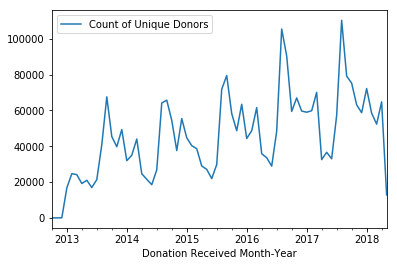

In [18]:
df3_month.plot(x='Donation Received Month-Year', y='Total Donations', kind='line')
df3_month.plot(x='Donation Received Month-Year', y='Mean Donation', kind='line')
df3_month.plot(x='Donation Received Month-Year', y='Count of Donations', kind='line')
df3_month.plot(x='Donation Received Month-Year', y='Count of Unique Donors', kind='line')
plt.show()


Okay this is interesting, there is definitely some seasonality to the donations, as can be seen by the hills and valleys in the graph. Monetary value is generally only a proxy for the frequency of donations. We may want to consider how we might further draw out the relationships for Recency-Frequency-Monetary Value. There are a couple of very large donations which are highlighted by the large spikes in the graph. No doubt, these were likely donations by organisations rather than private individuals. 



## Frequency Distribution

We can also visualise the frequency with which each of the donations have occured. Since we have a large outlier ($60 000), it's best to do some binning to better show the graph. I've arbitrarily used the following bins:



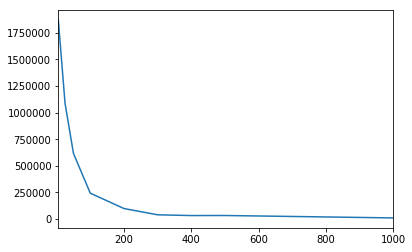

In [54]:
bins = [5, 25, 50, 100, 200, 300, 400, 500, 1000, 5000]
df3_freq = df3['Donation Amount'].value_counts(bins=bins).sort_index()
df3_freq.plot(x='Donation Amount', y='Donation Amount count', kind= 'line')
plt.show()

#df3_norm = (df3['Donation Amount'] - df3['Donation Amount'].mean())/(df3['Donation Amount'].max() - df3['Donation Amount'].mean())

## Classifying Donors

There are several aspects that we might like to look for to categorise the donor. It's generally well known that a major proportion of the funding raised is donated by a small percentage of the population. If we can stratify the donor base to gain this insight then we might be able to more narrowly target populations, creating the the best lift. 
### The 80/20 Rule
To begin, I'll be challenging the 80/20 rule. I'd like to first test the hypothesis that 80% of the donations in monetary value come from 20% percent of the popluation. I'll also only look at the most recent 12 months, as it might be that donors from previous years are less significant to future projections.

We can do this using the datetime timedelta method.


In [20]:
beginning_date = df3['Donation Received Date'].max() - dt.timedelta(days=365)
end_date = df3['Donation Received Date'].max()

print("The focus period begins at:", beginning_date)
print("The focus period ends at:", end_date)

The focus period begins at: 2017-05-09 11:38:47
The focus period ends at: 2018-05-09 11:38:47


In [82]:
donor_class = df3.loc[(beginning_date <= df3['Donation Received Date'])].groupby(by='Donor ID', as_index=False).agg({'Donation Amount': ['mean', 'sum', 'count']})
donor_class.columns = [' '.join(col).strip() for col in donor_class.columns.values]
# This calculates the 20% of the row count
top_20 = donor_class.shape[0]//100 * 20

donor_class.sort_values('Donation Amount sum', ascending=False, inplace=True)
donor_class.reset_index(drop=True, inplace=True)
#
print("The proportion of donations from the top 20% of donors is:", donor_class['Donation Amount sum'].loc[(donor_class.index <= top_20)].sum()/donor_class['Donation Amount sum'].sum())
donor_top20 = donor_class['Donor ID'].loc[(donor_class.index <= top_20)]

The proportion of donations from the top 20% of donors is: 0.736155643517


So what does this mean? Firstly, the dataframe was subsetting to include only the data that is from 9th May 2017. It was grouped by Donor ID. I flattened the dataframe as Donation amount was aggregated to include the mean, count and sum of the donations of the last year. 

The 80/20 rule has held true, approximately speaking.


## Survival Analysis



### Defining the Event
Survival analysis aims to predict when in time the some defined 'event' will occur for a person. When reviewing donors, it can be helpful to predict 'donor churn'. Donor churn can be difficult to define in the absence of information about subscription based donations.

The result of this is that some donors will not have experienced this. They could be regular donors for some of these projects. In survival analysis, if the event has not occurred during the period of observation, then the object will considered to be censored. This would be specifically called right-censoring.

This is where it really can get tricky with the application of survival analysis to donations. The individual may have already churned, or decided to no longer support the charity, but the full 12 month period may not have elapsed. This is a limitation of the approach. 

First we will define for each donor the donation frequency (mean frequency). The donor will be considered to have churned iff  their most recent donation be greater than n-periods of frequency before the observation end date. N-periods of the frequency can be decided through cross-validation, but will be n = 1 for this analysis.


In [85]:
obs_beginning_date = df3['Donation Received Date'].max() - dt.timedelta(days=365*2)
obs_end_date = df3['Donation Received Date'].max() - dt.timedelta(days=365)

print("The focus period begins at:", obs_beginning_date)
print("The focus period ends at:", obs_end_date)

df3_obs = df3.loc[(obs_beginning_date <= df3['Donation Received Date']) & (df3['Donation Received Date'] <= obs_end_date)]


The focus period begins at: 2016-05-09 11:38:47
The focus period ends at: 2017-05-09 11:38:47


In [86]:
df3_obs = df3.sort_values(by=['Donor ID', 'Donation Received Date'])

In [115]:
df3_obs['Time between donations'] = df3_obs.groupby('Donor ID')['Donation Received Date'].diff().fillna(0)
print(df3_obs.head())

3209653    0 days 00:00:00
3922619    0 days 00:00:00
2515350    0 days 00:00:00
2515351   82 days 04:56:09
2515344    0 days 13:08:50
Name: Time between donations, dtype: timedelta64[ns]


In [124]:
donor_groups = df3_obs[['Donor ID', 'Donation Received Date']].groupby('Donor ID')
time_diff = donor_groups.apply(lambda df: df['Donation Received Date'].diff().mean().fillna(0))
#https://stackoverflow.com/questions/29722704/fastest-way-to-calculate-average-of-datetime-rows-using-pandas
print(time_diff.head())

Donor ID
00000ce845c00cbf0686c992fc369df4                        NaT
00002783bc5d108510f3f9666c8b1edd                        NaT
00002d44003ed46b066607c5455a999a           35 days 18:37:54
00002eb25d60a09c318efbd0797bffb5   209 days 19:21:06.500000
0000300773fe015f870914b42528541b                        NaT
dtype: timedelta64[ns]


In [104]:
n_periods = 1


if df3_obs['Churn Date'] > df3_obs['Most Recent Donation']:
    df3_obs['Churn Flag'] = "Y"
else:
    df3_obs['Churn Flag'] = "N"

print(df3_obs['Churn Flad'].head())
        

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [111]:
# donor_class.sort_values('Donation Amount count', ascending=False, inplace=True)
# donor_class.reset_index(drop=True, inplace=True)
# donor_class.loc[donor_class.index <= top_20]
df3_obs.loc['Churn Date'] = obs_end_date - dt.timedelta(df3_obs.loc['Frequency of donations'])

KeyError: 'the label [Frequency of donations] is not in the [index]'

In [117]:
print(df3_obs.head())

                               Project ID                       Donation ID  \
3209653  5bab6101eed588c396a59f6bd64274b6  598691d82438952e2e4f3ed50531fd2a   
3922619  9db61b1b1e43a7b256eec9b20b42d854  024a4665bdb59f32027395aea3b0ed55   
2515350  e2beb818569f66adaa4ced21ca299ac6  08ed72ce14c548e8131a7dd7b8561988   
2515351  eb6d91cbeab5037ca2f45fc3f6a4de8c  158f00637416b7c41fcde429b10c3c41   
2515344  64f54f1efcbeb986114a7a13e6b27257  e3162fdec64ed91de1aa096cf75ba032   

                                 Donor ID Donation Included Optional Donation  \
3209653  00000ce845c00cbf0686c992fc369df4                                 Yes   
3922619  00002783bc5d108510f3f9666c8b1edd                                 Yes   
2515350  00002d44003ed46b066607c5455a999a                                 Yes   
2515351  00002d44003ed46b066607c5455a999a                                 Yes   
2515344  00002d44003ed46b066607c5455a999a                                 Yes   

         Donation Amount  Donor Cart S